In [20]:
import os
import torch
import numpy as np 
import pandas as pd 
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image
import torch
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
import time
from IPython.display import clear_output
from torchvision.models import resnet34, ResNet34_Weights

In [3]:
# Check if the "pytorch_unet.py" file exists
if not os.path.exists("pytorch_unet.py"):
    
    # Check if the "pytorch_unet" directory exists
    if not os.path.exists("pytorch_unet"):
        
        # If the "pytorch_unet" directory does not exist, clone the GitHub repository
        !git clone https://github.com/usuyama/pytorch-unet.git
    
    # Change the current working directory to the "pytorch-unet" directory
    %cd pytorch-unet

Cloning into 'pytorch-unet'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 67 (delta 6), reused 10 (delta 5), pack-reused 55 (from 1)
Receiving objects: 100% (67/67), 338.19 KiB | 11.27 MiB/s, done.
Resolving deltas: 100% (24/24), done.
/kaggle/working/pytorch-unet


In [1]:
# Check if a GPU is available; if not, raise an exception
if not torch.cuda.is_available():
    raise Exception("GPU not available. CPU training will be too slow.")

print("Device name:", torch.cuda.get_device_name(0))

Device name: Tesla P100-PCIE-16GB


In [2]:
class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True):
        super().__init__()
        
        # Loop through the files in the red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        
    def combine_files(self, r_file: Path, g_dir, b_dir, nir_dir, gt_dir):
        # Combine file paths for different spectral bands into a dictionary
        files = {'red': r_file, 
                 'green': g_dir / r_file.name.replace('red', 'green'),
                 'blue': b_dir / r_file.name.replace('red', 'blue'), 
                 'nir': nir_dir / r_file.name.replace('red', 'nir'),
                 'gt': gt_dir / r_file.name.replace('red', 'gt')}
        return files
        
    def __len__(self):
        # Return the number of files in the dataset
        return len(self.files)
     
    def open_as_array(self, idx, invert=False, include_nir=False):
        # Open image files as arrays, optionally including NIR channel
        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)
    
        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
    
        if invert:
            raw_rgb = raw_rgb.transpose((2, 0, 1))
    
        # Normalize pixel values
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)
        
    def open_mask(self, idx, add_dims=False):
        # Open ground truth mask as an array
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask == 255, 1, 0)
        
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    
    def __getitem__(self, idx):
        # Get an item from the dataset (image and mask)
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=True), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.int64)
        
        return x, y
    
    def open_as_pil(self, idx):
        # Open an image as a PIL image
        arr = 256 * self.open_as_array(idx)
        return Image.fromarray(arr.astype(np.uint8), 'RGB')
    
    def __repr__(self):
        # Return a string representation of the dataset
        s = 'Dataset class with {} files'.format(self.__len__())
        return s


In [3]:
base_path = Path('/kaggle/input/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_training')
data = CloudDataset(base_path/'train_red', 
                    base_path/'train_green', 
                    base_path/'train_blue', 
                    base_path/'train_nir',
                    base_path/'train_gt')
len(data)
data.files[0]

{'red': PosixPath('/kaggle/input/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_training/train_red/red_patch_62_3_by_18_LC08_L1TP_064014_20160420_20170223_01_T1.TIF'),
 'green': PosixPath('/kaggle/input/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_training/train_green/green_patch_62_3_by_18_LC08_L1TP_064014_20160420_20170223_01_T1.TIF'),
 'blue': PosixPath('/kaggle/input/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_training/train_blue/blue_patch_62_3_by_18_LC08_L1TP_064014_20160420_20170223_01_T1.TIF'),
 'nir': PosixPath('/kaggle/input/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_training/train_nir/nir_patch_62_3_by_18_LC08_L1TP_064014_20160420_20170223_01_T1.TIF'),
 'gt': PosixPath('/kaggle/input/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_training/train_gt/gt_patch_62_3_by_18_LC08_L1TP_064014_20160420_20170223_01_T1.TIF')}

In [4]:
# Print shapes of image and label at index 2
print(data[2][0].shape, data[2][1].shape)

torch.Size([4, 384, 384]) torch.Size([384, 384])


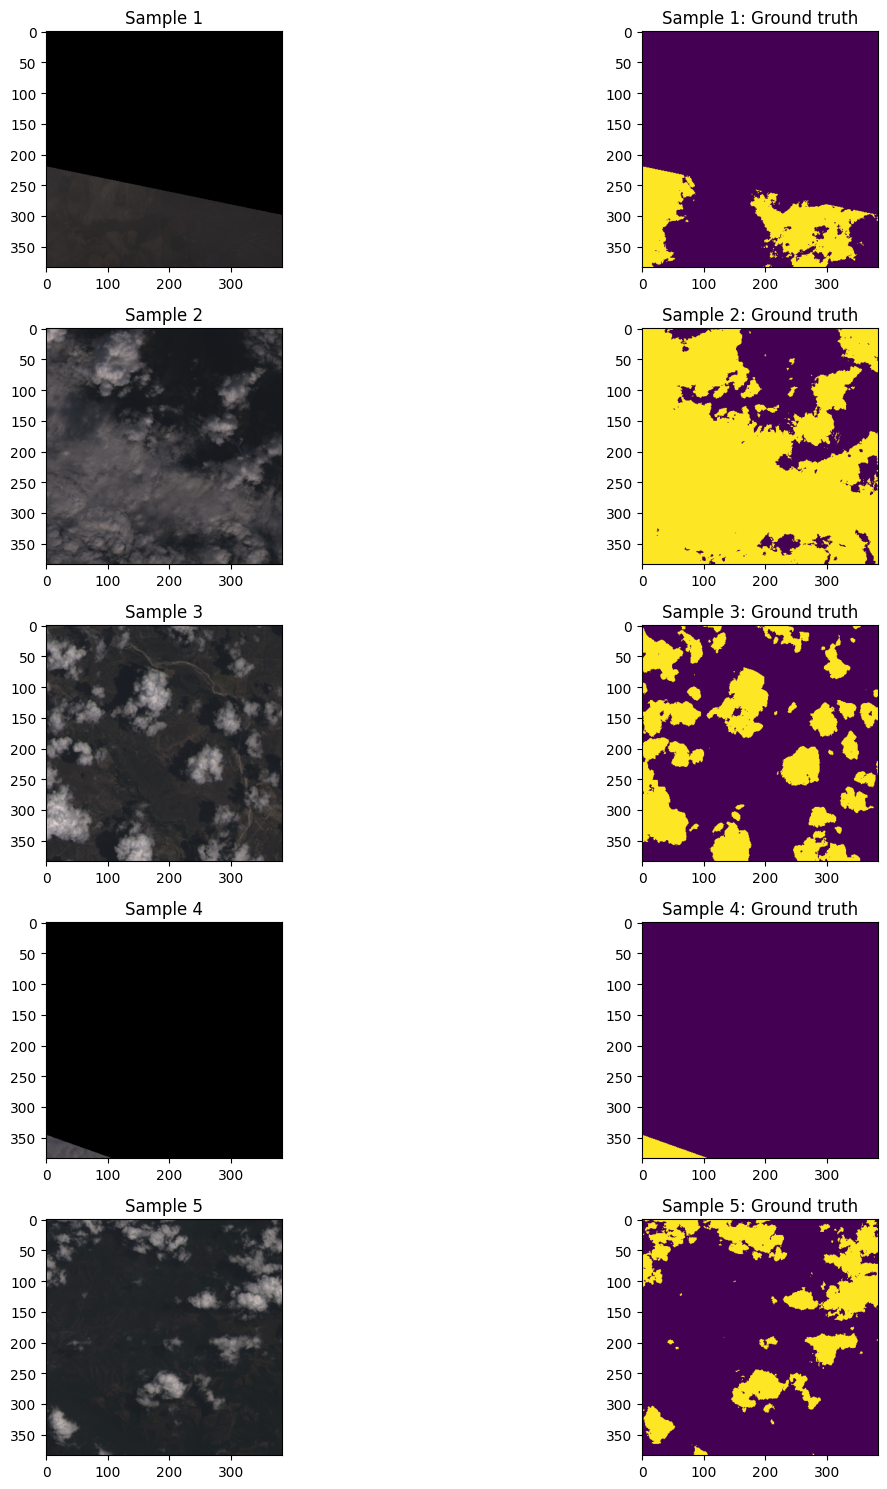

In [5]:
# Create a subplot grid for displaying the images and masks
fig, ax = plt.subplots(5, 2, figsize=(15, 15))

# Generate 5 random sample indices
sample_indices = random.sample(range(len(data)), 5)

# Iterate through the sample indices and display images and masks
for i, idx in enumerate(sample_indices):
    ax[i, 0].imshow(data.open_as_array(idx))
    ax[i, 0].set_title(f'Sample {i + 1}')
    
    ax[i, 1].imshow(data.open_mask(idx))
    ax[i, 1].set_title(f'Sample {i + 1}: Ground truth')

plt.tight_layout()
plt.show()

In [6]:
# Split the dataset into training and validation subsets
train_ds, valid_ds = torch.utils.data.random_split(data, (5800, 2600))

# Create a data loader for the training dataset
# - Batch size: 12, meaning each iteration provides a batch of 10 samples
# - Shuffle the data during training to introduce randomness
train_dl = DataLoader(train_ds, batch_size=10, shuffle=True)

# Create a data loader for the validation dataset with the same settings as the training loader
valid_dl = DataLoader(valid_ds, batch_size=10, shuffle=True)

# Retrieve the next batch of data from the training data loader for inspection
xb, yb = next(iter(train_dl))

# Print the shapes of the input batch (xb) and label batch (yb) tensors
print("Input Batch Shape:", xb.shape)
print("Label Batch Shape:", yb.shape)

Input Batch Shape: torch.Size([10, 4, 384, 384])
Label Batch Shape: torch.Size([10, 384, 384])


In [7]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )  

class UNet(nn.Module):

    def __init__(self, n_class, in_channels=4):
        super().__init__()
                
        self.dconv_down1 = double_conv(in_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

In [8]:
model = UNet(2)

print(model)

UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kerne

In [9]:
# testing one pass
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([10, 4, 384, 384]), torch.Size([10, 384, 384]))

In [10]:
pred = model(xb)
pred.shape

torch.Size([10, 2, 384, 384])

In [21]:
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        # Modify first layer of ResNet34 to accept custom number of channels
        base_model = resnet34(weights=None)
        base_model.conv1 = torch.nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        self.base_layers = list(base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        
        self.upconv4 = self.expand_block(512, 256)
        self.upconv3 = self.expand_block(256*2, 128)
        self.upconv2 = self.expand_block(128*2, 64)
        self.upconv1 = self.expand_block(64*2, 64)
        self.upconv0 = self.expand_block(64*2, out_channels)
        
    def forward(self, x):

        # Contracting Path
        layer0 = self.layer0(x)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        # Expansive Path
        upconv4 = self.upconv4(layer4)
        upconv3 = self.upconv3(torch.cat([upconv4, layer3], 1))
        upconv2 = self.upconv2(torch.cat([upconv3, layer2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, layer1], 1))
        upconv0 = self.upconv0(torch.cat([upconv1, layer0], 1))

        return upconv0
        
    def expand_block(self, in_channels, out_channels):
        expand = nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
        )
        return expand

In [18]:
model = UNET(4, 2)
x = torch.randn(1, 4, 256, 256)
y = model(x)
print(y.shape)


TypeError: UNET.forward() takes 2 positional arguments but 3 were given

In [22]:
UNET = UNET(4, 2)

In [23]:
pred = UNET(xb)
pred.shape

torch.Size([10, 2, 384, 384])

In [24]:
def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    model.cuda()

    train_loss, valid_loss = [], []
    overall_acc = []
    current_acc = 0.0

    best_acc = 0.0
    
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0
            
            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss.detach()*dataloader.batch_size

                if step % 100 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())
                
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)
            current_acc = (current_acc + epoch_acc)/2
            overall_acc.append(current_acc)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss, overall_acc    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()




In [25]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(UNET.parameters(), lr=0.01)
train_loss, valid_loss, overall_acc = train(UNET, train_dl, valid_dl, loss_fn, opt, acc_metric, epochs=10)

Epoch 9/9
----------
valid Loss: 0.2269 Acc: 0.9191793203353882
----------
Training complete in 23m 60s


In [30]:
#convert these lists to PyTorch tensors before calling the .cpu() method.
train_loss = torch.item(train_loss)
valid_loss = torch.item(valid_loss)
overall_acc = torch.item(overall_acc)

AttributeError: module 'torch' has no attribute 'item'

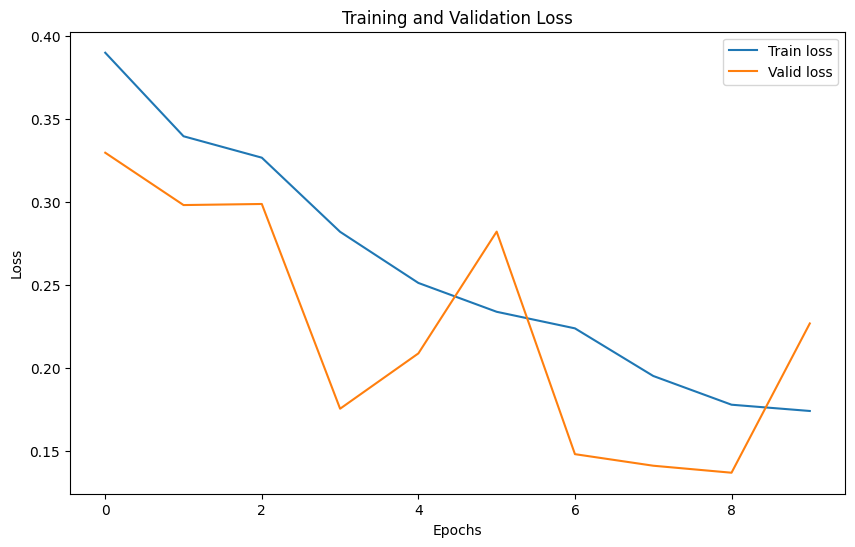

In [28]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label='Train loss') 
plt.plot(valid_loss, label='Valid loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

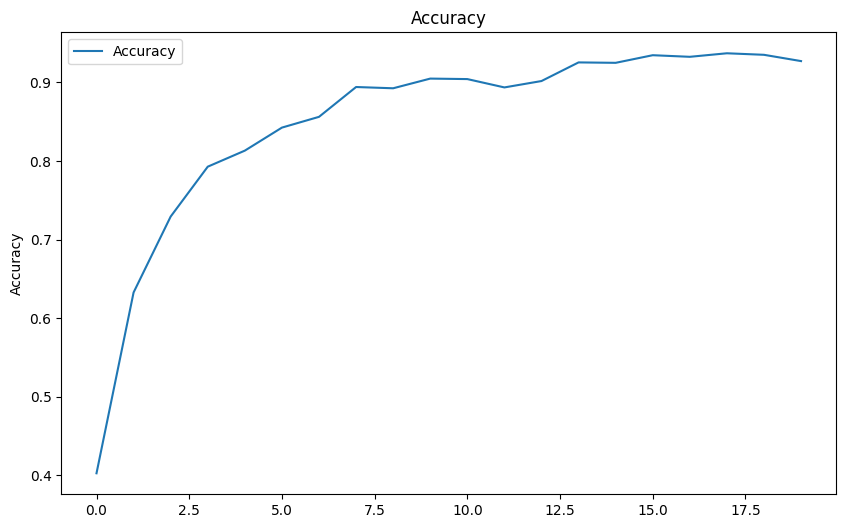

In [31]:
plt.figure(figsize=(10,6))
plt.plot(overall_acc, label='Accuracy')
plt.legend()
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.show()

In [32]:
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

In [33]:
xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = UNET(xb.cuda())

predb.shape

torch.Size([10, 2, 384, 384])

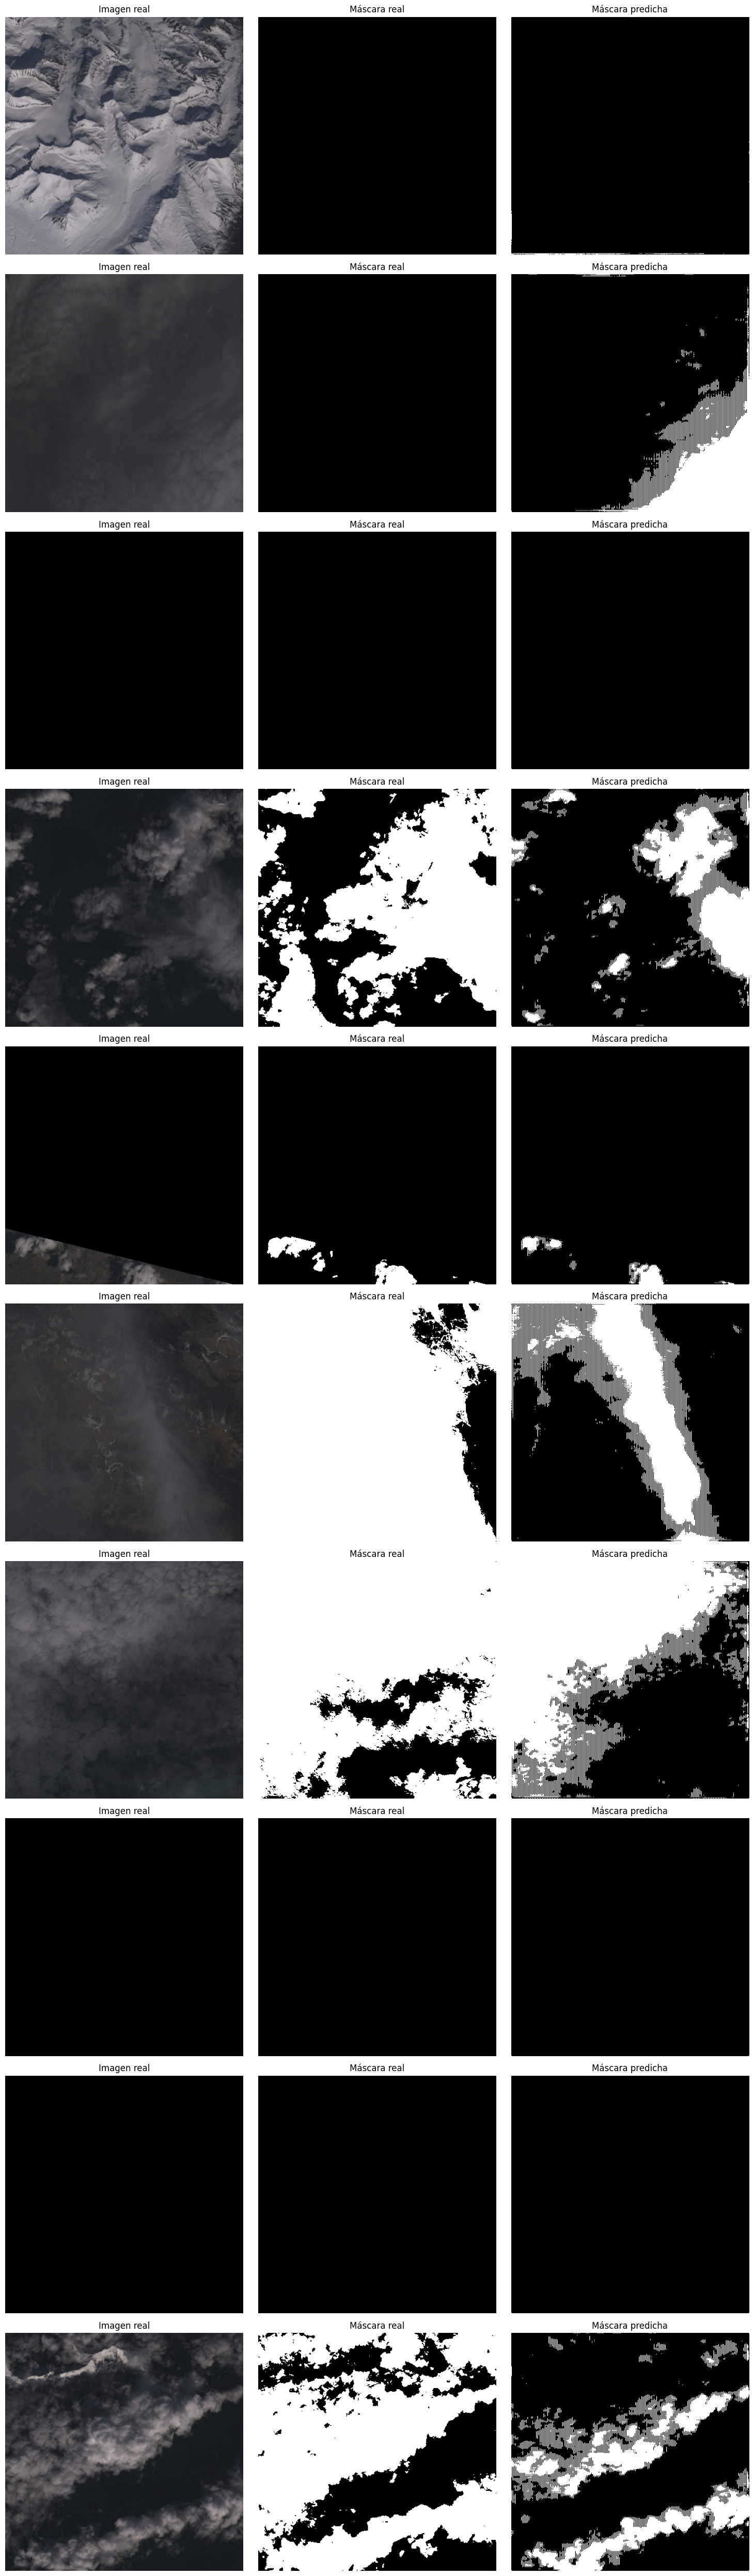

In [ ]:
bs = min(10, xb.shape[0])  # 

fig, ax = plt.subplots(bs, 3, figsize=(15, bs * 5))

for i in range(bs):
    # Imagen real
    ax[i, 0].imshow(batch_to_img(xb, i))
    ax[i, 0].set_title("Imagen real")
    ax[i, 0].axis("off")

    # Máscara real (ground truth)
    ax[i, 1].imshow(yb[i].squeeze(), cmap="gray")
    ax[i, 1].set_title("Máscara real")
    ax[i, 1].axis("off")

    # Máscara predicha
    ax[i, 2].imshow(predb_to_mask(predb, i), cmap="gray")
    ax[i, 2].set_title("Máscara predicha")
    ax[i, 2].axis("off")

plt.tight_layout()
plt.show()
